
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

In [2]:
# Bibliotecas básicas
import pandas as pd
import numpy as np

# Bibliotecas relacionadas ao treinamento do modelo
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold

from transformers import DistilBertTokenizer, DistilBertModel
from gensim.models import KeyedVectors

# Bibliotecas relacionadas a exibição de gráficos
import matplotlib.pyplot as plt

In [3]:
# Carregando modelo de transformer pré-treinado e tokenizer (DistilBERT)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [4]:
# Carregando modelo pré-treinado de vetores de palavras (utilizado no feature-based encoding)
word_vectors = KeyedVectors.load_word2vec_format('../embeddings/wiki.pt.vec', binary=False)

In [5]:
# Carregando dataset
df = pd.read_csv('../datasets/buscape_preprocessed_balanced_cleared.csv')

In [6]:
df.shape

(13620, 2)

In [7]:
# Montando um batch de apenas 1000 instâncias
batch_1 = df[:8000]

In [8]:
# Verificando quantidades de rating
batch_1['rating'].value_counts()

rating
0    6810
1    1190
Name: count, dtype: int64

In [9]:
# Limpando lista de sentenças e definindo labels
texts = batch_1['review_text'].tolist()
labels = batch_1['rating'].tolist()

In [10]:
# Dividindo dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [11]:
# Conferindo quantidades
print(f'textos para treino: {len(train_texts)}')
print(f'textos para teste: {len(test_texts)}')
print(f'labels para treino: {len(train_labels)}')
print(f'labels para teste: {len(test_labels)}')

textos para treino: 6400
textos para teste: 1600
labels para treino: 6400
labels para teste: 1600


#### Função que gera incorporações baseadas em recursos usando vetores de palavras pré-treinados

In [12]:
def generate_feature_based_embedding(text):
    words = text.split()
    embeddings = [word_vectors[word] for word in words if word in word_vectors]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(300)

#### Gerando feature-based embeddings para treino

In [13]:
train_feature_based_embeddings = np.array([generate_feature_based_embedding(text) for text in train_texts])
test_feature_based_embeddings = np.array([generate_feature_based_embedding(text) for text in test_texts])

#### Tokenizando

In [14]:
train_inputs = tokenizer(train_texts, padding=True, truncation=True, max_length=50, return_tensors="pt")
test_inputs = tokenizer(test_texts, padding=True, truncation=True, max_length=50, return_tensors="pt")

#### Gerando transformer-based embeddings

In [15]:
with torch.no_grad():
    train_outputs = model(**train_inputs).last_hidden_state
transformer_embeddings = train_outputs.numpy()

In [16]:
with torch.no_grad():
    test_outputs = model(**test_inputs).last_hidden_state
test_transformer_embeddings = test_outputs.numpy()

#### Foi gerado uma matriz de 3 dimensões de transformer embeddings de treino e test;
#### Optamos pelo reshape desta matriz de transformers embeddings;

In [17]:
print(transformer_embeddings.shape)
print(test_transformer_embeddings.shape)

(6400, 50, 768)
(1600, 50, 768)


In [18]:
# Reshape das matrizes
reshaped_transformer_embeddings = transformer_embeddings.reshape(transformer_embeddings.shape[0], -1)
reshaped_test_transformer_embeddings = transformer_embeddings.reshape(test_transformer_embeddings.shape[0], -1)

In [19]:
print(reshaped_transformer_embeddings.shape)
print(reshaped_test_transformer_embeddings.shape)

(6400, 38400)
(1600, 153600)


#### Concatenando train_feature_based_embeddings e reshaped_transformer_embeddings
#### Concatenando test_feature_based_embeddings e reshaped_test_transformer_embeddings

In [20]:
combined_embeddings = np.concatenate((train_feature_based_embeddings, reshaped_transformer_embeddings), axis=1)
combined_test_embeddings = np.concatenate((test_feature_based_embeddings, reshaped_test_transformer_embeddings), axis=1)

In [21]:
print(combined_embeddings.shape)
print(combined_test_embeddings.shape)

(6400, 38700)
(1600, 153900)


#### Convertendo dados para PyTorch tensors

In [22]:
train_embeddings = torch.tensor(combined_embeddings, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.float32)

test_embeddings = torch.tensor(combined_test_embeddings, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32)

In [23]:
X = train_embeddings
y = train_labels = torch.tensor(train_labels, dtype=torch.float32)

/tmp/ipykernel_32067/2366203256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = train_labels = torch.tensor(train_labels, dtype=torch.float32)


In [24]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(p=0.05)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

In [48]:
input_size = X.shape[1]
hidden_size = 24
num_classes = len(np.unique(y))
learning_rate = 5e-4
num_epochs = 5
batch_size = 32

In [49]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [50]:
fold_accuracies = []
fold_f1_scores = []

train_losses = []
train_accuracies = []

data_reports = []

test_losses = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = MLP(input_size, hidden_size, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    epoch_losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0
        test_loss = 0.0
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size].long()
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * batch_X.size(0)
        
        train_loss_item = epoch_loss / len(X_train)
        train_losses.append(train_loss_item)
        
        test_loss += loss.item() * batch_X.size(0)
        test_losses.append(test_loss / len(X_test))
        
        
        _, predicted = outputs.max(1)
        correct += predicted.eq(batch_y).sum().item()
        total += batch_X.size(0)
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)
        
        model.eval()
        test_outputs = []
        with torch.no_grad():
            for i in range(0, len(X_test), batch_size):
                batch_X = X_test[i:i+batch_size]
                outputs = model(batch_X)
                test_outputs.extend(outputs.argmax(dim=1).tolist())
        
        fold_accuracy = accuracy_score(y_test.numpy(), test_outputs)
        fold_accuracies.append(fold_accuracy)
        
        fold_f1 = f1_score(y_test.numpy(), test_outputs)
        fold_f1_scores.append(fold_f1)
        #print(f"fold: {fold}, epoca: {epoch+1}, train_loss: {train_loss_item:.4f}, train_acc: {train_accuracy:4f}, fold_acc: {fold_accuracy:.4f}, fold_f1_score: {fold_f1:.4f}" )
        print(f"fold: {fold}, epoca: {epoch+1}, fold_acc: {fold_accuracy:.4f}, fold_f1_score: {fold_f1:.4f}" )
        
        data_reports.append([fold, fold_accuracy, fold_f1])
        columns = ['fold', 'fold_accuracy', 'fold_f1_score']

print('-'*100)
report_df = pd.DataFrame(data_reports, columns=columns)
mean_acc = report_df['fold_accuracy'].mean()
mean_f1_score = report_df['fold_f1_score'].mean()
print(f'Média Folds Accuracies = {mean_acc:.4f}')
print(f'Média F1 Scores = {mean_f1_score:.4f}')

fold: 1, epoca: 1, fold_acc: 0.8578, fold_f1_score: 0.1495
fold: 1, epoca: 2, fold_acc: 0.8656, fold_f1_score: 0.2456
fold: 1, epoca: 3, fold_acc: 0.8688, fold_f1_score: 0.2759
fold: 1, epoca: 4, fold_acc: 0.8688, fold_f1_score: 0.3636
fold: 1, epoca: 5, fold_acc: 0.8719, fold_f1_score: 0.3971
fold: 2, epoca: 1, fold_acc: 0.8641, fold_f1_score: 0.2301
fold: 2, epoca: 2, fold_acc: 0.8688, fold_f1_score: 0.2759
fold: 2, epoca: 3, fold_acc: 0.8672, fold_f1_score: 0.2857
fold: 2, epoca: 4, fold_acc: 0.8594, fold_f1_score: 0.2857
fold: 2, epoca: 5, fold_acc: 0.8594, fold_f1_score: 0.2969
fold: 3, epoca: 1, fold_acc: 0.8500, fold_f1_score: 0.0000
fold: 3, epoca: 2, fold_acc: 0.8500, fold_f1_score: 0.0000
fold: 3, epoca: 3, fold_acc: 0.8500, fold_f1_score: 0.0000
fold: 3, epoca: 4, fold_acc: 0.8500, fold_f1_score: 0.0000
fold: 3, epoca: 5, fold_acc: 0.8516, fold_f1_score: 0.1739
fold: 4, epoca: 1, fold_acc: 0.8516, fold_f1_score: 0.0404
fold: 4, epoca: 2, fold_acc: 0.8594, fold_f1_score: 0.22

Text(0, 0.5, 'Loss')

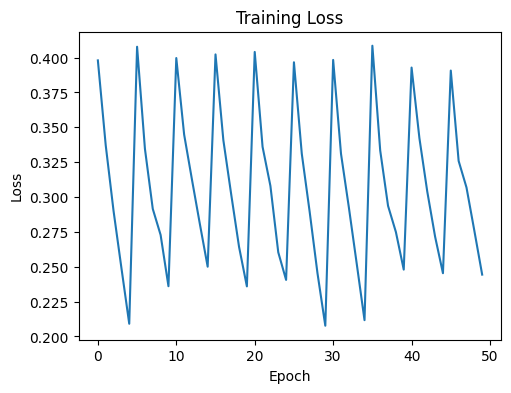

In [51]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

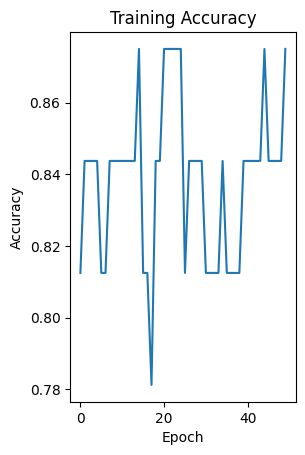

In [52]:
plt.subplot(1, 2, 2)
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

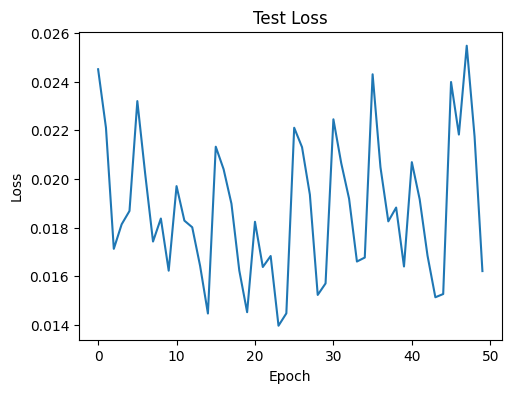

In [53]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

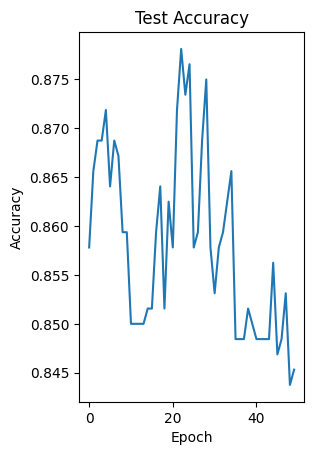

In [54]:
plt.subplot(1, 2, 2)
plt.plot(fold_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')